In [1]:
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
from SignalRecognition.cwt_learner.wavelet_feature_engineering import CWT_learner
from signal_database.labelSelectedData import SignalDB,SignalBundle

ImportError: No module named signal_data_base

In [7]:
import matplotlib.pyplot as plt
from plot_generator import plotResult_colorbars

In [66]:
sdb = SignalDB('test', path='./data')
training_data_ = sdb.get_labeleddata()

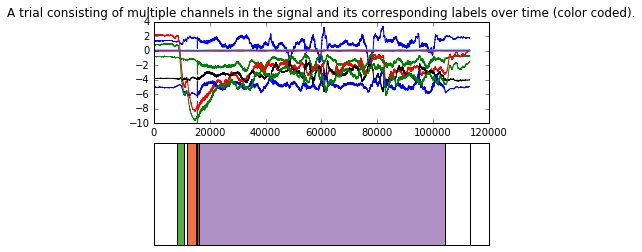

In [67]:
plt.figure()
plt.subplot(2,1,1)
plt.title("A trial consisting of multiple channels in the signal and its corresponding labels over time \
(color coded).")
for channel in training_data_[0].signal_bundle.signals:
    plt.plot(channel)
plt.subplot(2,1,2)
labels = training_data_[0].labels
plotResult_colorbars(labels, range(len(labels)))
plt.show()

Now we create a `cwt_learner` object and adding training data to it. 

`cwt_learn.add_training_data` can be used by adding an array of signals and their corresponding labels.

In [85]:
cwt_learn = CWT_learner(signal_indices = [0,1,2,3])
training_data = training_data_[1:2]
testing_data = training_data_[0:1]
for ld in training_data:
    labels = [label for label in ld.labels]
    signals = []
    signals.append(list(np.array(ld.signal_bundle.signals[0]) +  np.array(ld.signal_bundle.signals[1]))) 
    signals.append(ld.signal_bundle.signals[2])
    
    signals.append(list(np.array(ld.signal_bundle.signals[3]) +  np.array(ld.signal_bundle.signals[4]))) 
    signals.append(ld.signal_bundle.signals[5])    
    
    cwt_learn.add_training_data(signals,labels)

In [86]:

type(data_set.signal_bundle.signals[0])

list

The default ML algorithm is `sklearn.neural_network. MLPClassifier`, but you can change this by providing an argument for classifer in 
`CWT_learner.train(self,classifier = MLPClassifier())` 

In [ ]:
# cwt_learn.train(classifier=SVC())
cwt_learn.train()
# cwt_learn.train(classifier=KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree'))

In [111]:

labels = cwt_learn.fit(testing_data[0].signal_bundle.signals)


In [101]:
# Plotting

plt.figure()
plt.subplot(1,1,1)
plt.title("Training Data")
for ii in range(0,1):
    ax = plt.subplot(18,1,2*ii + 1)
    plt.plot(training_data[ii].signal_bundle.signals[0])
    ax.get_yaxis().set_visible(False)
    plt.subplot(18, 1, 2*ii + 2)
    plotResult_colorbars(training_data[ii].labels, range(len(training_data[ii].labels)))
plt.show()

In [94]:
%matplotlib

Using matplotlib backend: TkAgg


In [ ]:
plt.figure()

ax = plt.subplot(2, 1, 1)
plt.title("Test Example")
plt.plot(testing_data[0].signal_bundle.signals[0])
ax.get_yaxis().set_visible(False)

plt.subplot(2, 1, 2)
plotResult_colorbars(labels, range(len(labels)))

plt.show()